In [153]:
import numpy as np
import pandas as pd
import sklearn

from scipy import interp
import matplotlib.pyplot as plt
from numpy import ravel

from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

import itertools

import sklearn.metrics as metrics

import matplotlib.pyplot as plt

import random

import scipy

# Set seed
random.seed(53189)
np.random.seed(53189)

In [154]:
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2



def fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight=None):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    sample_weight = None
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes p-value for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    sample_weight = None
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((np.asarray(predictions_one), np.asarray(predictions_two)))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    return 10**calc_pvalue(aucs, delongcov)

In [170]:
A = pd.read_excel("C:/Users/arman/Desktop/Tables/Review4.xlsx")
print(A.shape)

y = A["hopsitaldays2"]
y = y.ravel()
print(y.shape)

X = A
del X["HospitaldDays..nur.auf.Station."]
del X["STS"]
del X["STSACC"]
del X["hopsitaldays2"]
del X["ID"]
Z = pd.DataFrame(data = X) # Create data frame for colomn names
X = np.array(X, dtype = float)
print(X.shape)

(312, 88)
(312,)
(312, 83)


In [171]:
from sklearn.preprocessing import StandardScaler, Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X = imp.fit_transform(X)

feature_scaler = StandardScaler()  
X = feature_scaler.fit_transform(X)

C:\Users\arman\Anaconda3\envs\KerasGPU3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [172]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=4)

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [174]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

grid_param_rf = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

classifier_rf = GridSearchCV(estimator=rfc, param_grid=grid_param_rf, cv=inner_cv, scoring='roc_auc')

In [175]:
fit_rf_large   = classifier_rf.fit(X_train, y_train)
probs_rf_large = fit_rf_large.predict_proba(X_test)
fpr_rf_large, tpr_rf_large, thresholds_rf_large = roc_curve(y_test, probs_rf_large[:, 1])
auc_rf_large = auc(fpr_rf_large, tpr_rf_large)

C:\Users\arman\Anaconda3\envs\KerasGPU3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


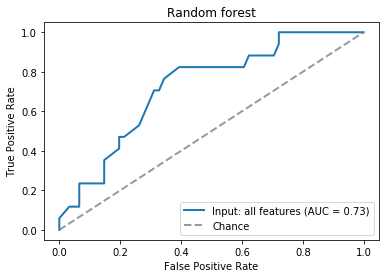

In [176]:
# Plot ROC curve and area under the curve
plt.plot(fpr_rf_large, tpr_rf_large, lw=2, alpha=1,
         label='Input: all features (AUC = %0.2f)' % auc_rf_large)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         label='Chance', alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random forest')
plt.legend(loc="lower right")
plt.show()